In [15]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [16]:
data = pd.read_csv('../../Data1/kospi_data.csv')
print(data.dtypes)

Date       object
Close     float64
Open      float64
High      float64
Low       float64
Volume    float64
Change    float64
dtype: object


In [17]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace = True)

In [18]:
X = data.iloc[:, 1:]
y = data.iloc[:, :1]
print(X)
print(y)

               Open     High      Low       Volume  Change
Date                                                      
1981-05-01   123.60   123.60   123.60    3330000.0  0.0098
1981-05-02   123.50   123.50   123.50    2040000.0 -0.0008
1981-05-04   120.60   120.60   120.60    1930000.0 -0.0235
1981-05-06   120.70   120.70   120.70    1690000.0  0.0008
1981-05-07   119.30   119.30   119.30    1480000.0 -0.0116
...             ...      ...      ...          ...     ...
2022-08-25  2459.79  2477.26  2455.32  426230000.0  0.0122
2022-08-26  2489.14  2497.76  2476.75  520090000.0  0.0015
2022-08-29  2432.06  2432.89  2417.01  448750000.0 -0.0218
2022-08-30  2441.21  2453.91  2433.48     327210.0  0.0099
2022-08-31  2433.47  2473.75  2426.14     397290.0  0.0086

[11024 rows x 5 columns]
              Close
Date               
1981-05-01   123.60
1981-05-02   123.50
1981-05-04   120.60
1981-05-06   120.70
1981-05-07   119.30
...             ...
2022-08-25  2477.26
2022-08-26  2481.03
2022-08

In [19]:
ms = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y)

ratios = [.8, 0, 0.2]

train_cnt = int(len(data) * ratios[0])
valid_cnt = int(len(data) * ratios[1])
test_cnt = int(len(data) * ratios[2])

X_train = X_ss[:train_cnt, :]
X_valid = X_ss[train_cnt:train_cnt + valid_cnt, :]
X_test = X_ss[train_cnt + valid_cnt:, :]

y_train = y_ms[:train_cnt, :]
y_valid = y_ms[train_cnt:train_cnt + valid_cnt, :]
y_test = y_ms[train_cnt + valid_cnt:, :]

print("Training Shape", X_train.shape, y_train.shape)
print("Validing Shape", X_valid.shape, y_valid.shape)
print("Testing Shape", X_test.shape, y_test.shape)

Training Shape (8819, 5) (8819, 1)
Validing Shape (0, 5) (0, 1)
Testing Shape (2205, 5) (2205, 1)


In [6]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_valid_tensors = Variable(torch.Tensor(X_valid))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_valid_tensors = Variable(torch.Tensor(y_valid))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_f = torch.reshape(X_train_tensors, (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_valid_tensors_f = torch.reshape(X_valid_tensors, (X_valid_tensors.shape[0], 1, X_valid_tensors.shape[1]))
X_test_tensors_f = torch.reshape(X_test_tensors, (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

print("Training Shape", X_train_tensors_f.shape, y_train_tensors.shape)
print("Validing Shape", X_valid_tensors_f.shape, y_valid_tensors.shape)
print("Testing Shape", X_test_tensors_f.shape, y_test_tensors.shape)

Training Shape torch.Size([8819, 1, 5]) torch.Size([8819, 1])
Validing Shape torch.Size([0, 1, 5]) torch.Size([0, 1])
Testing Shape torch.Size([2205, 1, 5]) torch.Size([2205, 1])


In [7]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, 
                           num_layers = num_layers, batch_first = True)
        self.fc_1 = nn.Linear(hidden_size, 128)
        self.fc = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        output, (hn, cn) = self.lstm(x, (h_0, c_0))
        hn = hn.view(-1, self.hidden_size)
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

In [8]:
num_epochs = 600
learning_rate = 0.0001

input_size = 5
hidden_size = 10
num_layers = 1

num_classes = 1
model = LSTM(num_classes, input_size, hidden_size, num_layers, X_train_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

for epoch in range(num_epochs):
    outputs = model.forward(X_train_tensors_f)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train_tensors)
    loss.backward()
            
    optimizer.step()

    
    if (epoch + 1) % 500 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch + 1, loss.item()))


Epoch: 500, loss: 0.01801


In [25]:
df_x_ss = ss.transform(data.iloc[:, 1:])
df_y_ms = ms.transform(data.iloc[:, :1])

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))

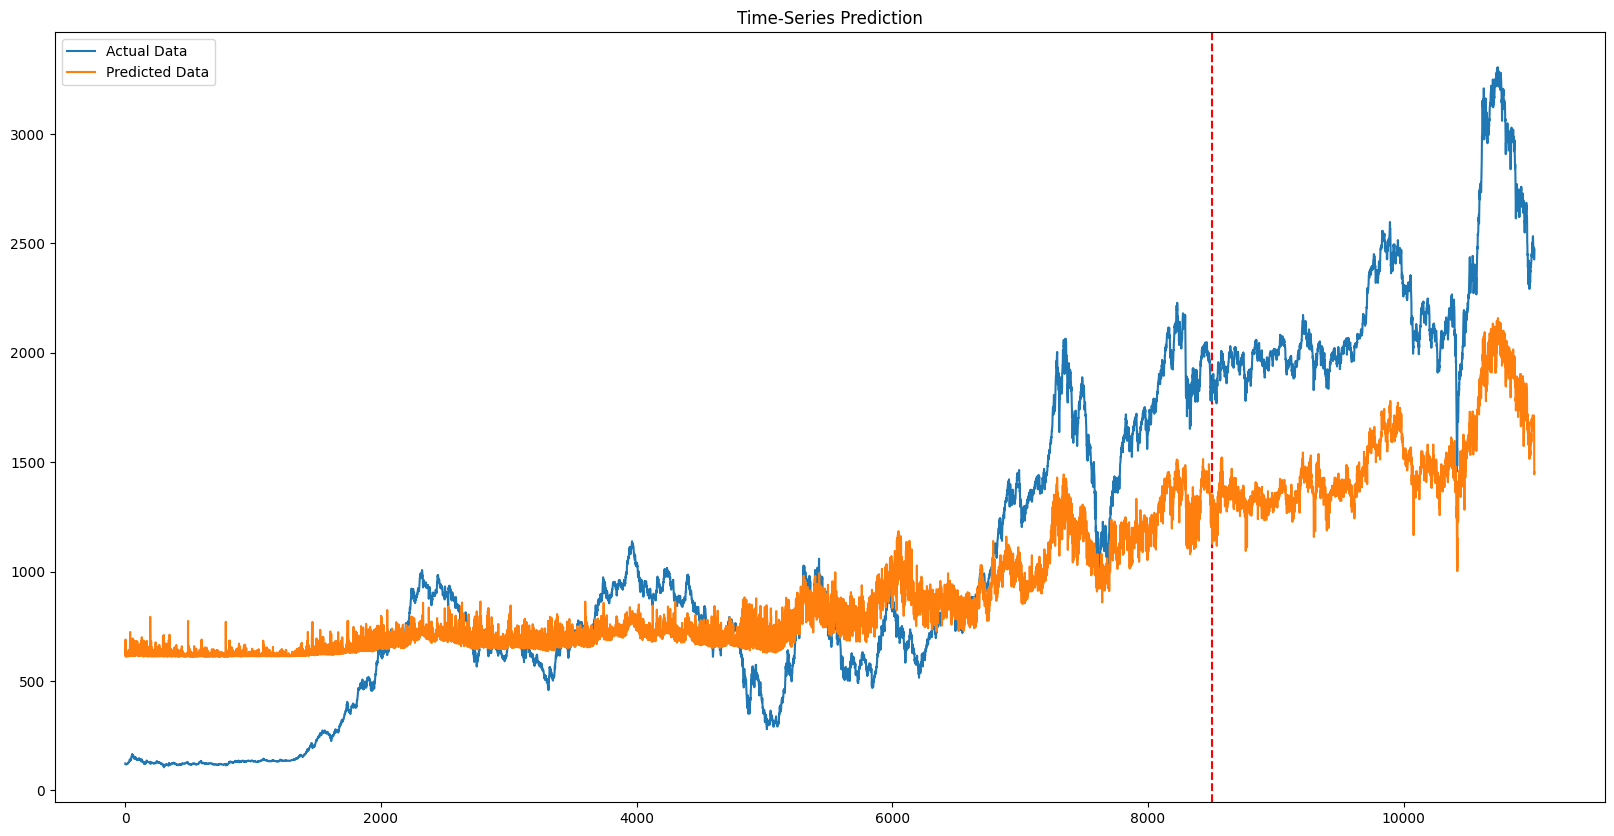

In [10]:
train_predict = model(df_x_ss)
predicted = train_predict.data.numpy()
label_y = df_y_ms.data.numpy()

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)
plt.figure(figsize = (20, 10))
plt.axvline(x = 8500, c = 'r', linestyle = '--')

plt.plot(label_y, label = 'Actual Data')
plt.plot(predicted, label = 'Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

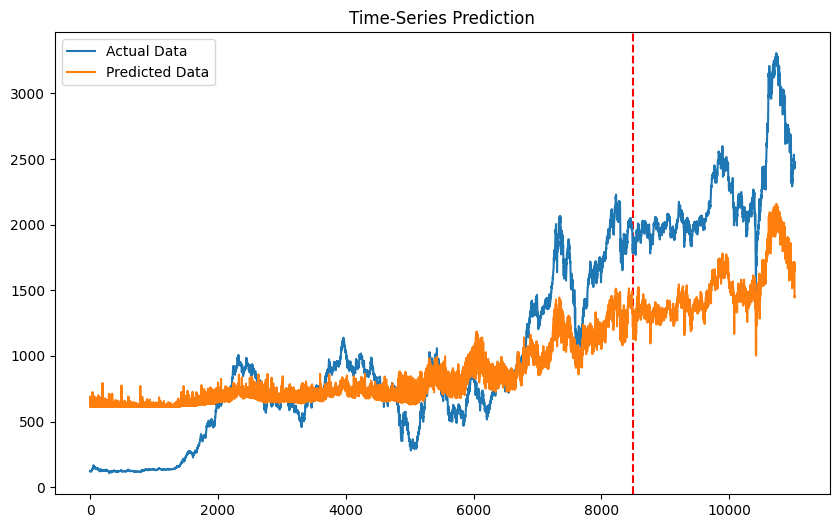

In [11]:
train_predict = model(df_x_ss)
predicted = train_predict.data.numpy()
label_y = df_y_ms.data.numpy()

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)
plt.figure(figsize = (10, 6))
plt.axvline(x = 8500, c = 'r', linestyle = '--')

plt.plot(label_y, label = 'Actual Data')
plt.plot(predicted, label = 'Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

In [295]:
# 모델 저장

PATH = "../../Model/model_LSTM1.pth"
torch.save(model.state_dict(), PATH)

In [151]:
# 예측 값 저장 ( for visualization )

pd.DataFrame(predicted).to_csv('../../Predict/LSTM_1.csv', )

In [152]:
# 불러오기

PATH = "../../Model/model_LSTM1.pth"

model = LSTM(num_classes, input_size, hidden_size, num_layers, X_train_tensors_f.shape[1]) 
model.load_state_dict(torch.load(PATH), strict=False)
model.eval()

LSTM(
  (lstm): LSTM(5, 2, batch_first=True)
  (fc_1): Linear(in_features=2, out_features=128, bias=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

In [153]:
def MAE(true, pred):
    return np.mean(np.abs(true-pred))

print('MAE SCORE : ', MAE(label_y, predicted))

MAE SCORE :  39.875328
